In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from mnist_model import generator,discriminator
import utils
l = tf.layers

## Hyperparam

In [2]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 2,
    x_dim = 784,
    reg_w = 0.,
    lr = 2e-4,
    logdir = 'gan_mnist/',
    name_model = 'model_latent24'
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data creation (unl)

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels
trainx = np.reshape(trainx,[-1,28,28,1])
testx = np.reshape(testx,[-1,28,28,1])
trainx_unl = trainx.copy()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build model

In [4]:
tf.reset_default_graph()

In [5]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['batch_size'])

iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

In [6]:
is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
# Construct generator and discriminator net
# samples = generator(noise,is_training_pl,reuse=False)
# real_score = discriminator(data,is_training_pl,reuse=False)
# fake_score = discriminator(samples,is_training_pl,reuse=True)

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(data,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer_dis = tf.train.AdamOptimizer(learning_rate=params['lr'],
                                               beta1=0.5, name='dis_optimizer')
optimizer_gen = tf.train.AdamOptimizer(learning_rate=params['lr'],
                                               beta1=0.5, name='gen_optimizer')

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS,
                                   scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS,
                                   scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer_gen.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer_dis.minimize(loss_d,var_list=disc_vars)

Tensor("discriminator/layer_3/leaky_relu/sub:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator_1/layer_3/leaky_relu/sub:0", shape=(100, 4, 4, 512), dtype=float32)


In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [8]:
saver = tf.train.Saver()
if tf.train.latest_checkpoint(os.path.join('./saved_models/',params['logdir'])) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(os.path.join('./saved_models/',params['logdir'])))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./saved_models/gan_mnist/model1


NotFoundError: Key discriminator/dense/bias not found in checkpoint
	 [[Node: save/RestoreV2_4 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_4/tensor_names, save/RestoreV2_4/shape_and_slices)]]
	 [[Node: save/RestoreV2_70/_91 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_278_save/RestoreV2_70", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op 'save/RestoreV2_4', defined at:
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/ioloop.py", line 760, in _run_callback
    ret = callback()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-7c15d6e2b819>", line 1, in <module>
    saver = tf.train.Saver()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 751, in _build_internal
    restore_sequentially, reshape)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 427, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 267, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/bruno/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key discriminator/dense/bias not found in checkpoint
	 [[Node: save/RestoreV2_4 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_4/tensor_names, save/RestoreV2_4/shape_and_slices)]]
	 [[Node: save/RestoreV2_70/_91 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_278_save/RestoreV2_70", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]


HBox(children=(IntProgress(value=0, max=20000), HTML(value='')))

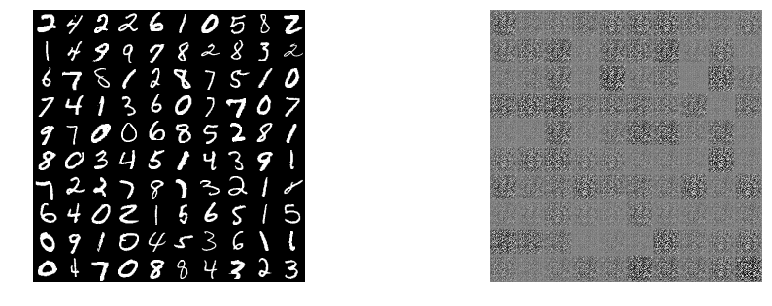

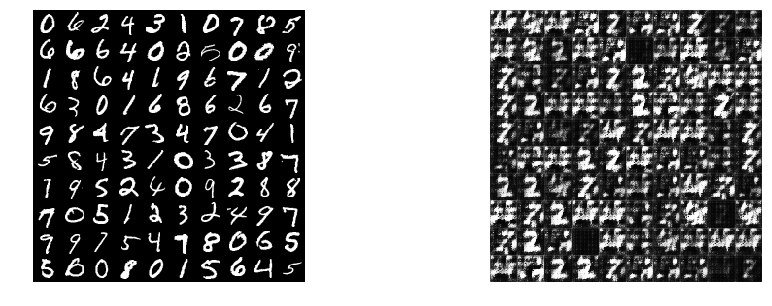

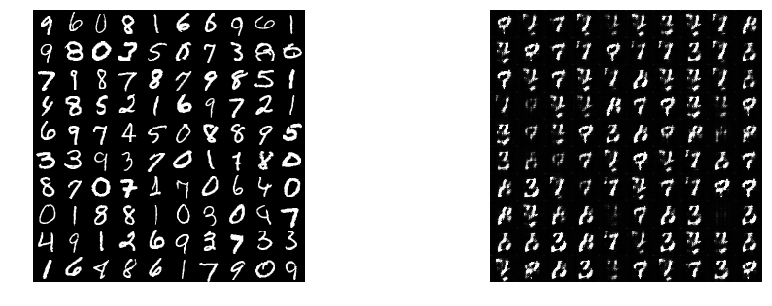

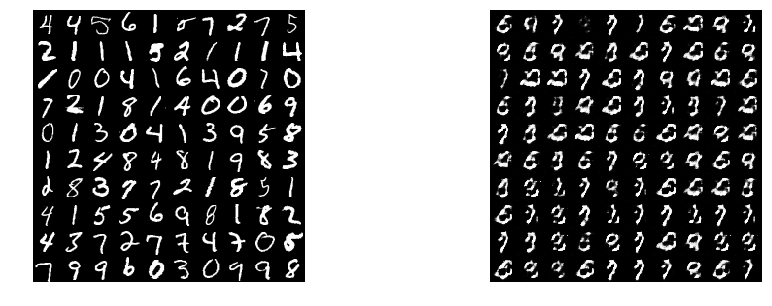

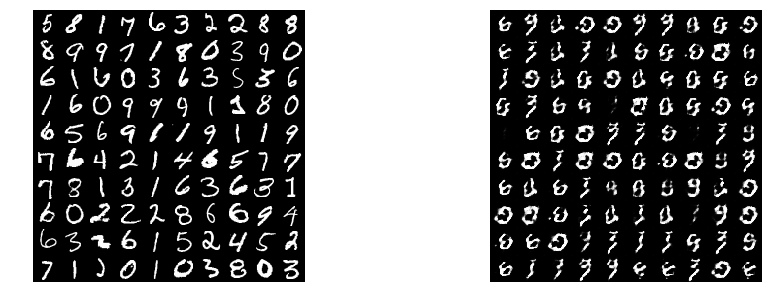

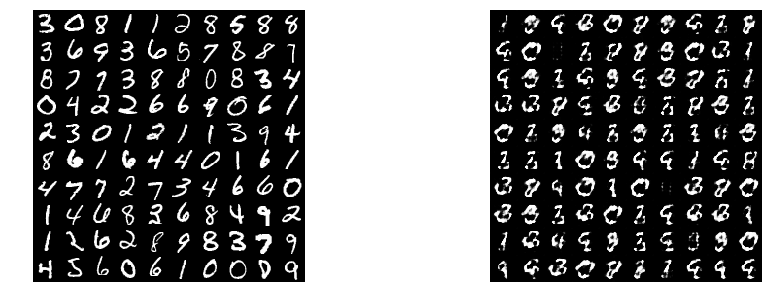

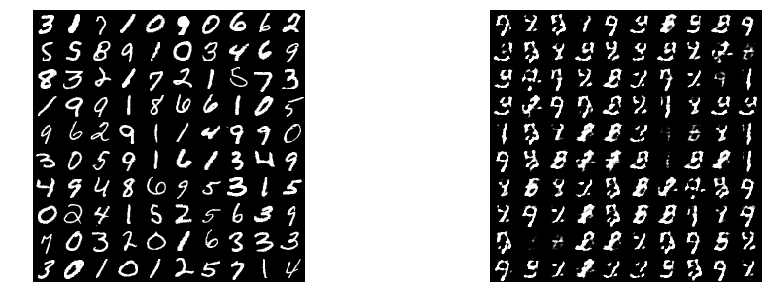

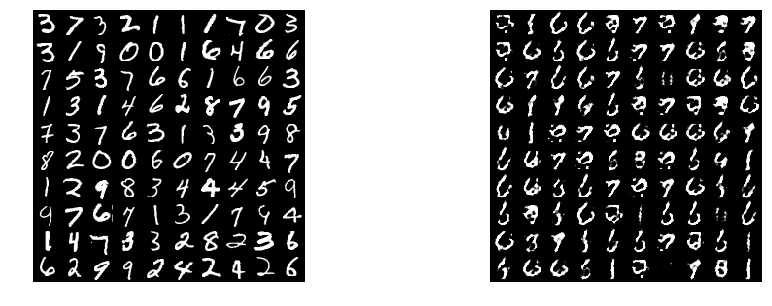

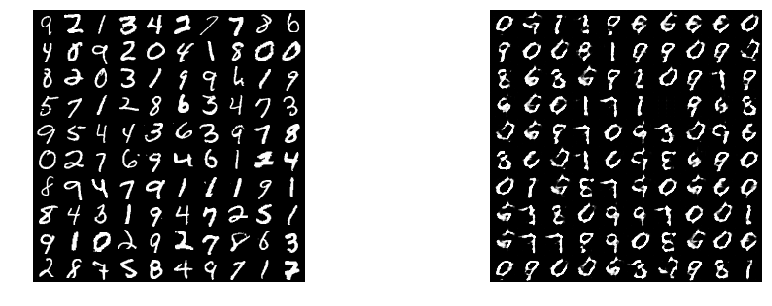

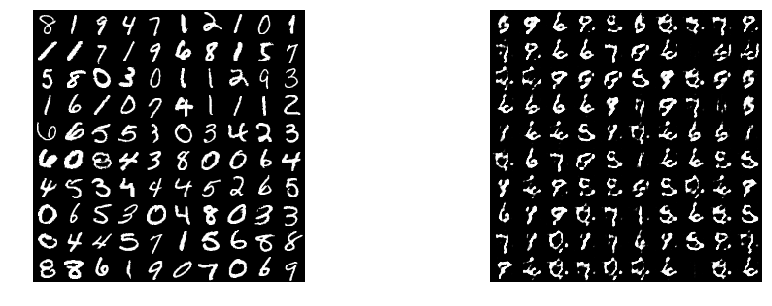

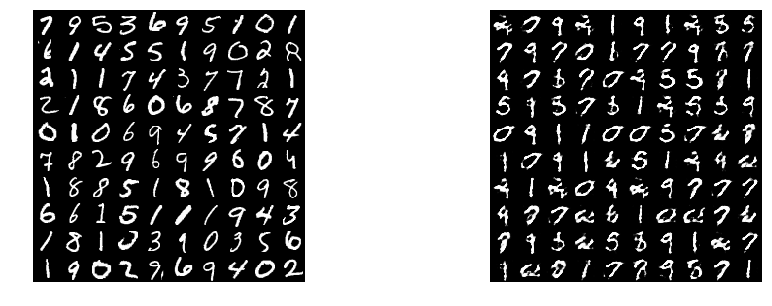

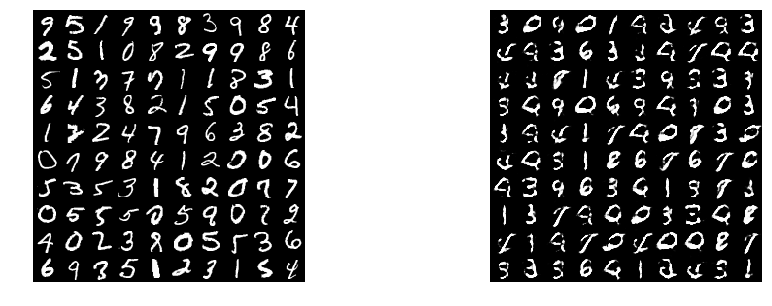

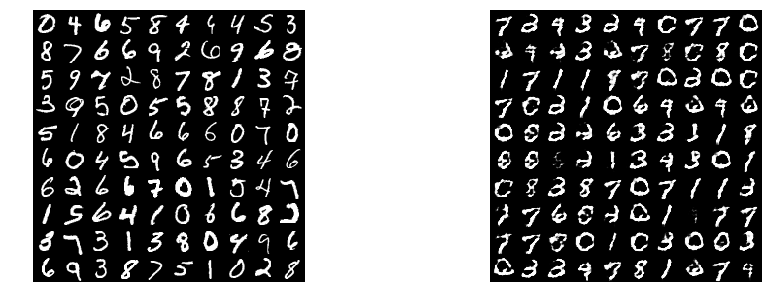

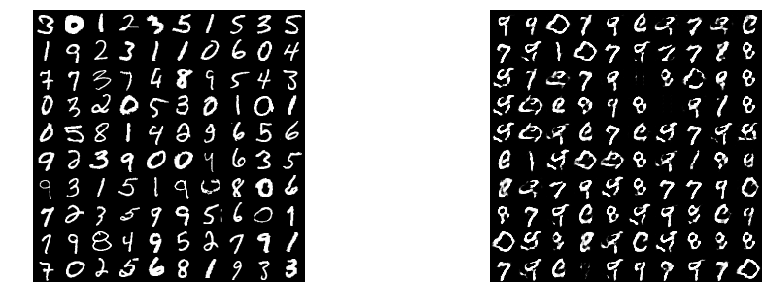

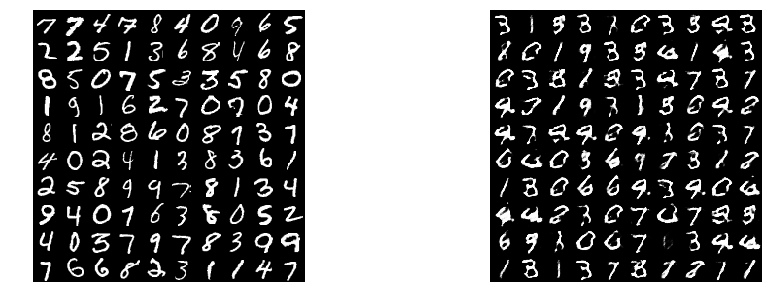

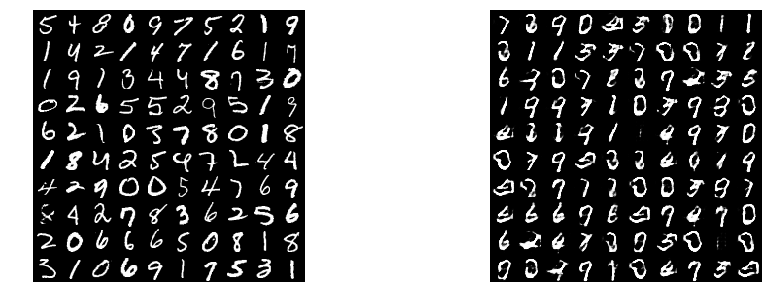

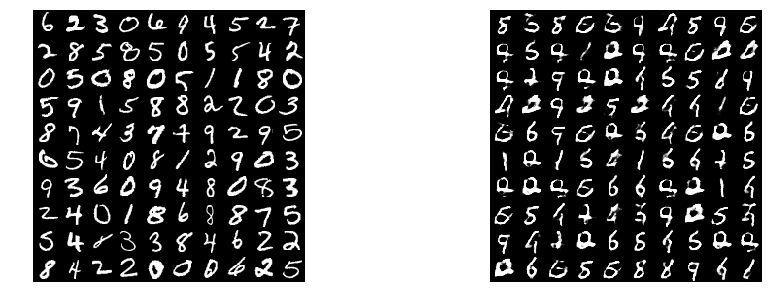

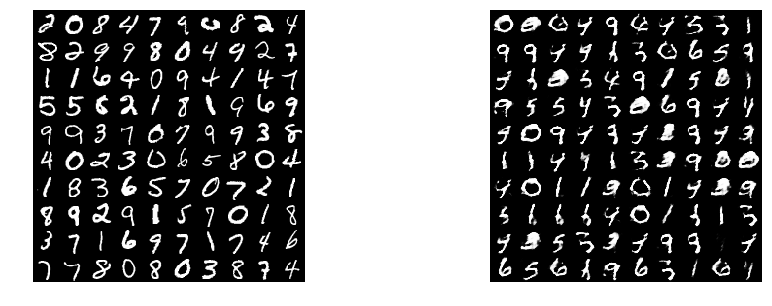

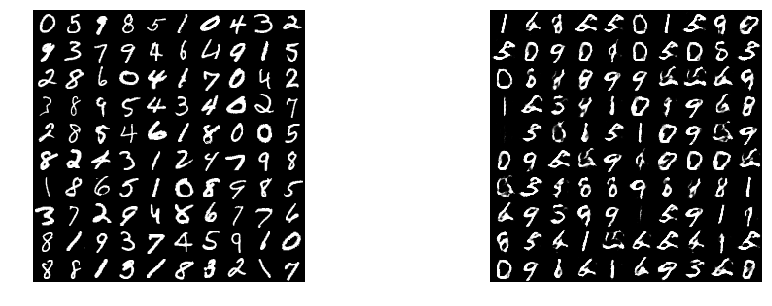

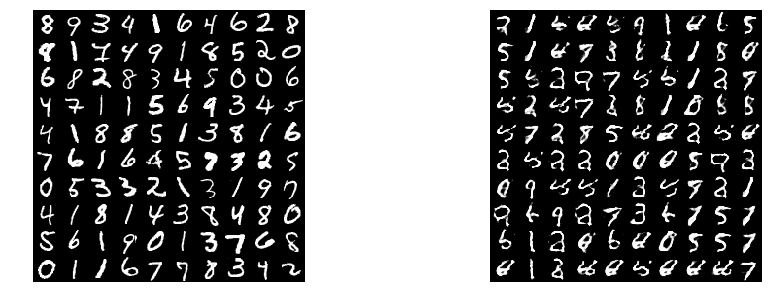

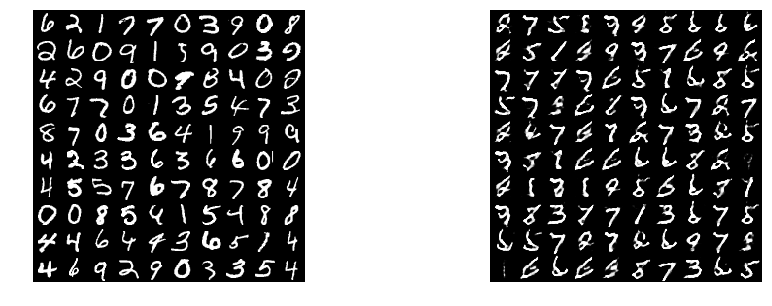

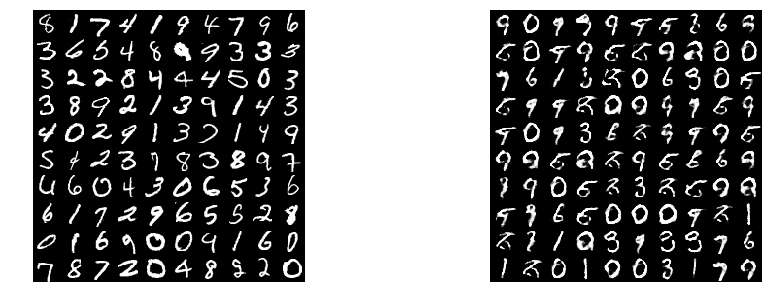

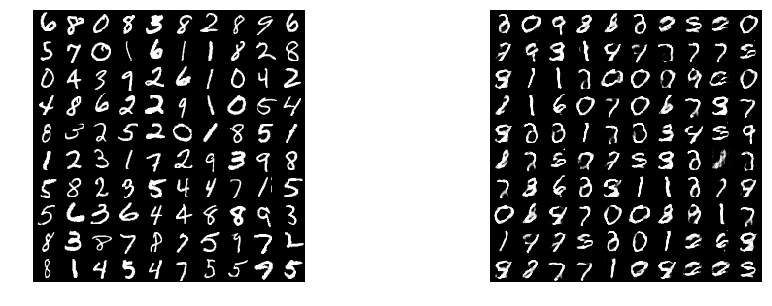

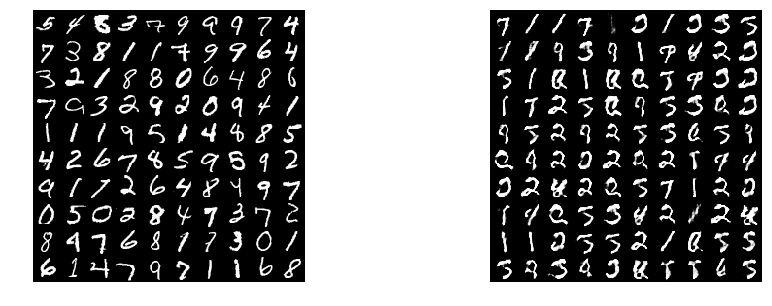

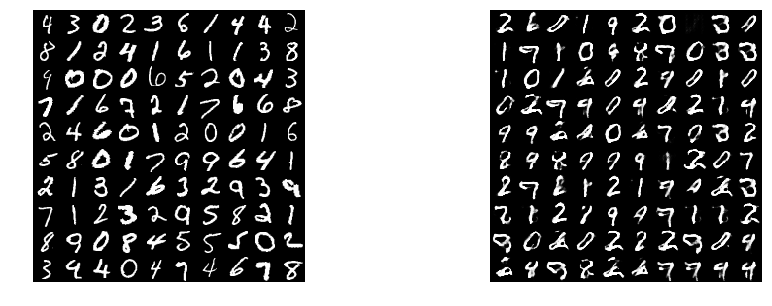

In [ ]:
fs = []
frames = []
np_samples = []
n_batches_viz = 1
viz_every = 100
lsd=[]
lsg=[]
for i in tqdm(range(20000)):
#     f, _= sess.run([[loss], train_op],{is_training_pl:True})
    ld,_=sess.run([loss_d,traind],{is_training_pl:True})
    lg,_=sess.run([loss_g, traing],{is_training_pl:True})
    lsd.append(ld); lsg.append(lg);

    if (i) % viz_every == 0:
        xx, yy = sess.run([data,samples],{is_training_pl:True})
#         print('iter nr : ',gstep)
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        show_digits(xx[:100])
        plt.subplot(122)
        show_digits(yy[:100])
        plt.show()


In [ ]:
if not os.path.exists(params['logdir']):
    os.makedirs(params['logdir'])
saver.save(sess, os.path.join('./saved_models/',params['logdir'],params['name_model']))

## Hyper param perturbation DNN

In [ ]:
params_dnn = dict(
    epsilon = .1,
    gamma = 0.1, #2.
    delta = 0.01,
    batch = 50,
    mc = 200,
    lr=1e-3,
    beta1 = 0.9,
    epoch = 4000,
    l2_w = 0.1,
    labeled = 10000
)

# labeled data

In [ ]:
labeled = params_dnn['labeled']
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:labeled])
    tys.append(trainy[trainy == j][:labeled])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys

nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']

show_digits(trainx[:1000])
plt.show()

In [ ]:
params_dnn = dict(
    epsilon = .1,
    gamma = 0.0, #2.
    delta = 0.01,
    batch = 50,
    mc = 200,
    lr=1e-3,
    beta1 = 0.9,
    epoch = 4000,
    l2_w = 0.1,
    labeled = 1
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainx, trainy))
train_dataset = train_dataset.shuffle(10000).repeat().batch(params_dnn['batch'])

test_dataset = tf.data.Dataset.from_tensor_slices((testx, testy))
test_dataset = test_dataset.repeat().batch(params_dnn['batch'])

iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                               train_dataset.output_shapes)
next_element, next_label = iterator.get_next()
next_label = tf.cast(next_label,tf.int64)

train_trigger = iterator.make_initializer(train_dataset)
test_trigger = iterator.make_initializer(test_dataset)

In [ ]:
z = tf.random_normal(shape=[params_dnn['mc'],params['z_dim']]) # samples = generator(noise,is_training_pl,reuse=False)
# perturb = tf.random_normal([params_dnn['mc'],params['z_dim']], mean=0, stddev=1)
# perturb_n = tf.nn.l2_normalize(perturb, dim=[1])
# z_pert = z + params_dnn['delta']* perturb_n
# z_pert = z + tf.random_normal([params_dnn['mc'],params['z_dim']], mean=0, stddev=0.1)

# samp_pert = generator(z_pert,is_training_pl,reuse=True)
samp = generator(z,is_training_pl,reuse=True)
# # samp_adv = samp + params_dnn['epsilon']* tf.nn.l2_normalize(samp_pert-samp,dim=[1])
# samp_adv = samp_pert

# f_samp_adv = soft(lenet(samp_adv,training_cnn))
f_samp = soft(lenet(samp,training_cnn))
# tan_consistency = tf.sqrt(1e-8 + tf.pow(f_samp_adv-f_samp,2))
# tan_loss = tf.reduce_mean(tan_consistency)

# _nabla = tf.gradients(tan_consistency, perturb)[0]

In [ ]:

# loss = xloss + params_dnn['gamma'] * tan_loss

## Vizualizing perturbation

In [ ]:
xx,yy = sess.run([samp,f_samp],{is_training_pl:False,training_cnn:False})

show_digits(xx[:100])

plt.show()


In [ ]:
plt.hist(yy.flatten())

## defining model

In [ ]:
def lenet(x,training_pl):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,32,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x,64,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x,1024,activation=tf.nn.relu)
        x = tf.layers.dropout(x,rate=0.4,training=training_pl)
        x = tf.layers.dense(x,10)
        return x
    
soft = lambda x: 1/(1+tf.exp(-x))    

In [ ]:
label = tf.cast(next_label,tf.int64)
training_cnn  = tf.placeholder(tf.bool,[])
logits = lenet(next_element,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=label)

In [ ]:
with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE):
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'))

correct_prediction = tf.equal(tf.argmax(logits,1),label)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#init
var = tf.global_variables(scope='classifier')
init_op = tf.variables_initializer(var_list=var)

## cnn training

In [ ]:
sess.run([train_trigger,init_op])
manifold=[];xentropy=[];vaccu=[];taccu=[];
for i in tqdm(range(params_dnn['epoch']+1)):
    xl,_,acc,tl = sess.run([xloss,train_op,accuracy,tan_loss],feed_dict={training_cnn:True,is_training_pl:False})
    manifold.append(tl); xentropy.append(xl);taccu.append(acc*100)
    if i % 100 == 0:
        sess.run(test_trigger)
        test_acc = 0
        for n in range(nr_batch_test):
            test_acc  += sess.run(accuracy,feed_dict={training_cnn:False,is_training_pl:False})
        test_acc /= nr_batch_test
        vaccu.append((test_acc*100,i))
        print("Step: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%".format(i, xl, acc * 100,test_acc*100))
        sess.run(train_trigger)
        
        if (i != 0) & (i % 500 ==0):
            v = np.vstack(vaccu)
            plt.figure(figsize=(15,5))
            plt.subplot(121)
            plt.plot(manifold)
            plt.plot(xentropy)
            plt.plot(manifold_cnn)
            plt.plot(xentropy_cnn)
            plt.subplot(122)
            plt.plot(v[:,1],v[:,0])
            plt.plot(taccu)
            plt.plot(v_cnn[:,1],v_cnn[:,0])
            plt.plot(taccu_cnn)

            plt.show()

In [ ]:
# manifold_cnn = manifold
# xentropy_cnn = xentropy
# v_cnn = v
# taccu_cnn = taccu